In [289]:
import snntorch as snn
from snntorch.functional import probe

import torch
from torch import nn, Tensor
from torch.nn import init

from collections import OrderedDict
import math

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

In [349]:
class Net(nn.Module):
    def __init__(self, dim_in, dim_out, hidden_dim, num_ff_layers, monitored_attributes=[]):
        super().__init__()

        layers = OrderedDict()
        for i in range(num_ff_layers):
            d_in = dim_in if i == 0 else hidden_dim
            d_out = dim_out if i == num_ff_layers - 1 else hidden_dim
            #alpha = 0. if i == num_ff_layers - 1 else torch.rand(d_out)
            alpha = torch.rand(d_out) * 0.1 + 0.9
            beta = torch.rand(d_out) * 0.1 + 0.9
            layers[f'fc{i + 1}'] = nn.Linear(d_in, d_out, bias=False)
            layers[f'lif{i + 1}'] = snn.Synaptic(
                alpha=alpha,
                beta=beta,
                init_hidden=True
            )
        self.model = nn.ModuleDict(layers)

        self.init_weights()

        self.overwrite_getattr()

        self.monitored_attributes = monitored_attributes
        self.monitors = []
        for attr in self.monitored_attributes:
            self.monitors.append(
                probe.AttributeMonitor(attr, False, self.model, instance=snn.Synaptic)
            )

    def init_weights(self):
        for name, parameter in self.named_parameters():
            if 'weight' in name:
                init.orthogonal_(parameter)

    def overwrite_getattr(self):
        for name, module in self.named_modules():
            module.__getattr__ = module.__getattribute__

    def reset_state(self):
        for name, module in self.named_modules():
            reset_fn = getattr(module, 'reset_hidden', None)
            if callable(reset_fn): reset_fn()
        for monitor in self.monitors:
            monitor.clear_recorded_data()

    def forward(self, x_seq: torch.Tensor):

        for name, module in self.model.items():
            x_seq = module(x_seq)

        return x_seq

In [350]:
# Another to plot any continuous variable over time.
def plot_traces(trace: Tensor, spk: Tensor = None, dim: tuple = (2,4),
                spike_height: float = 10, ylabel: str = 'V(t)') -> None:
    fig = plt.figure(figsize=(10, 4))
    gs = plt.GridSpec(*dim, figure=fig)
    if spk is not None:
        dat = 1.0*trace
        dat[spk>0.0] = spike_height
        dat = dat.detach().cpu().numpy()
    else:
        dat = trace.detach().cpu().numpy()
    for i in range(math.prod(dim)):
        if i==0:
            a0=ax=plt.subplot(gs[i])
        else:
            ax=plt.subplot(gs[i], sharey=a0)
        ax.axis("off")
        ax.plot(dat[:, i], alpha=0.6)
        if i == (dim[0] - 1) * dim[1]:
            ax.axis("on")
            ax.spines[['right', 'top']].set_visible(False)
            ax.set_ylabel(ylabel)
            ax.set_xlabel('t [ms]')

In [351]:
# Another to plot any continuous variable over time.
def plot_spikes(spk: Tensor, dim: tuple = (2,4)) -> None:
    fig = plt.figure(figsize=(10, 4))
    gs = plt.GridSpec(*dim, figure=fig)

    for i in range(math.prod(dim)):
        if i==0:
            a0=ax=plt.subplot(gs[i])
        else:
            ax=plt.subplot(gs[i],sharey=a0)
        #ax.axis("off")
        ax.imshow(spk[:, i].T, cmap=plt.cm.gray_r, aspect="auto", interpolation='none')
        ax.spines[['right', 'top']].set_visible(False)
        if i == (dim[0] - 1) * dim[1]:
            ax.axis("on")
            ax.set_ylabel("Neuron Number")
            ax.set_xlabel('Time Step')
        else:
            ax.xaxis.set_tick_params(labelbottom=False)
            ax.yaxis.set_tick_params(labelleft=False)

In [352]:
def raster_plot(spike_data, title=None, ax=None, labels=True):

    ax.imshow(spike_data, cmap=plt.cm.gray_r, aspect="auto", interpolation='none')
    if layer is not None:
        ax.title.set_text(title)
    if labels:
        ax.set_xlabel("Time step")
        ax.set_ylabel("Neuron Number")
    ax.spines[['right', 'top']].set_visible(False)
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))

def raster_plots(spike_data, title=None, max=None):

    fig = plt.figure()
    fig.suptitle(title)

    T, N, D = spike_data.shape
    if max is not None:
        N = min((N, max))
    for n in range(N):
        ax = fig.add_subplot(N, 1, n+1)
        example_spikes = spike_data[:, n, :].T

        #raster_plot(example_spikes, title=f'example {n+1}', ax=ax, labels=n+1 == N)
        raster_plot(example_spikes, ax=ax, labels=n+1 == N)

    plt.tight_layout()
    plt.show()


0

Attribute: mem
Layer: lif1
Layer: lif2

Attribute: spk
Layer: lif1
Layer: lif2


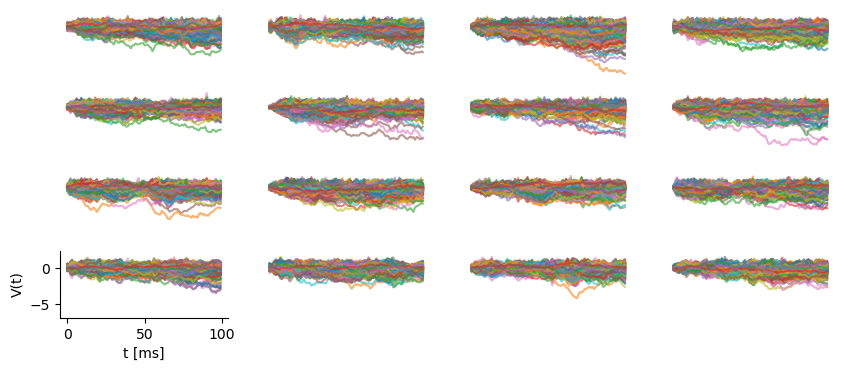

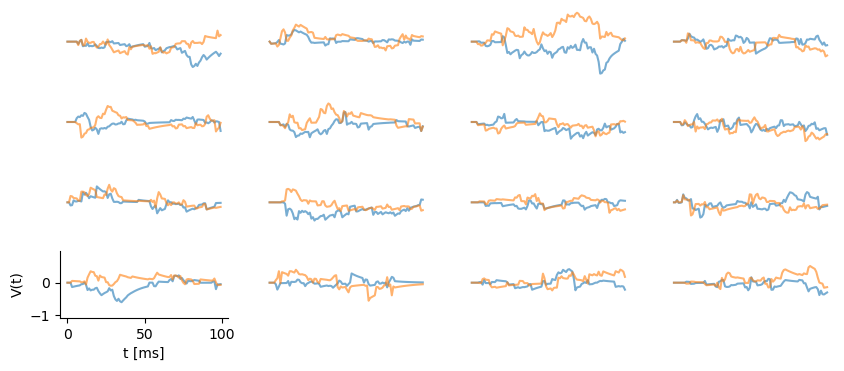

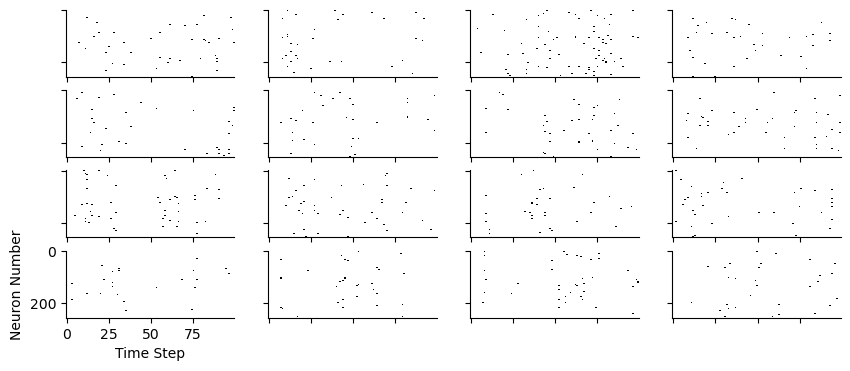

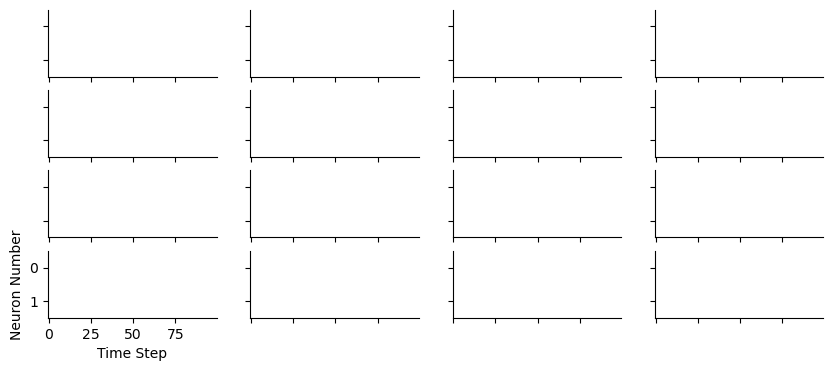

In [354]:
net = Net(8, 2, 256, 2, ['mem', 'spk'])

with torch.no_grad():

    for j in range(1):

        net.reset_state()
        print()
        print(j)
        for i in range(100):
            y = net(torch.randn([64, 8]))

        for monitor in net.monitors:
            print()
            print('Attribute:', monitor.attribute_name)
            for layer in monitor.monitored_layers:
                print('Layer:', layer)
                #print(monitor[layer])

                if monitor.attribute_name == 'spk':
                    spike_data = torch.stack(monitor[layer]) # [T, N, D]
                    #raster_plots(spike_data, f'Layer: {layer}', max=8)
                    plot_spikes(spike_data, dim=(4, 4))
                if monitor.attribute_name == 'mem':
                    mem_data = torch.stack(monitor[layer]) # [T, N, D]
                    #raster_plots(spike_data, f'Layer: {layer}', max=8)
                    plot_traces(mem_data, dim=(4, 4))

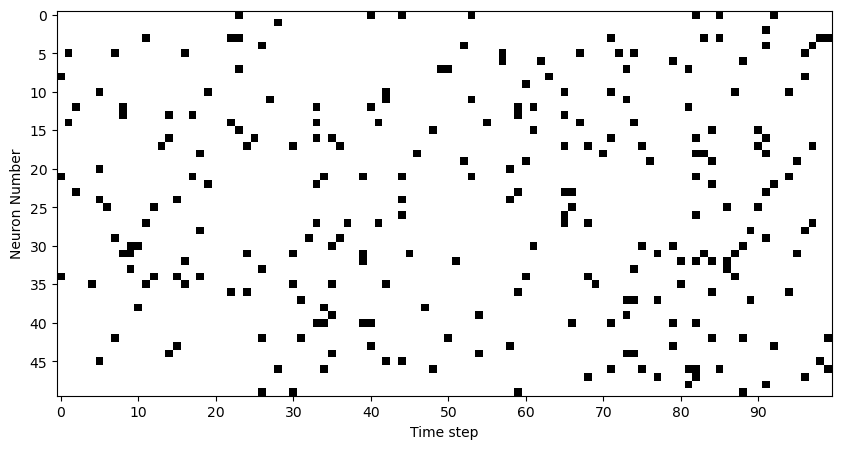

In [104]:
spike_data = torch.zeros((50, 100))
r = torch.rand_like(spike_data)
spike_data = torch.where(r > 0.95, 1, 0)

raster_plot(spike_data)